## 1. Import and Setup

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from collections import Counter
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Loading Dataset Paths and Basic Info

In [4]:
base_path = r'C:\Users\param\OneDrive\Desktop\EDA project\MY_data'
train_path = os.path.join(base_path, 'train')
class_names = os.listdir(train_path)

image_paths = []
labels = []

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    for img_file in os.listdir(class_folder):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(i)

print("Classes:", class_names)
print("Total Images:", len(image_paths))
print("Total Classes:", len(class_names))


Classes: ['Apple', 'avocado', 'Banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Total Images: 2301
Total Classes: 10


## 3. Image Size Statistics

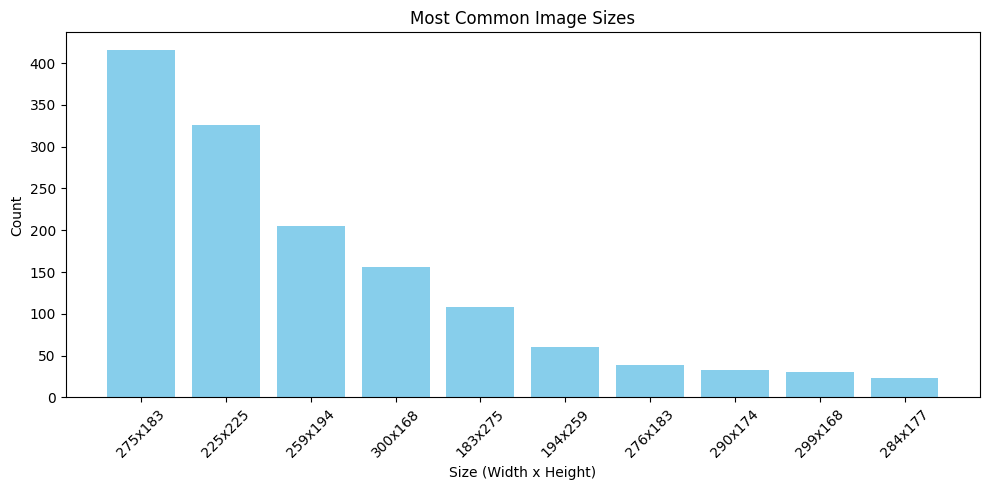

In [5]:
sizes = []
for path in image_paths:
    img = Image.open(path)
    sizes.append(img.size)

size_counts = Counter(sizes)
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

most_common_sizes = sorted_sizes[:10]
sizes_str = [f"{w}x{h}" for (w, h), _ in most_common_sizes]
counts = [count for _, count in most_common_sizes]

plt.figure(figsize=(10, 5))
plt.bar(sizes_str, counts, color='skyblue')
plt.title("Most Common Image Sizes")
plt.xlabel("Size (Width x Height)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Resize All Images to 128x128 using TensorFlow

In [6]:
import tensorflow as tf
import numpy as np

# Target size
TARGET_SIZE = (128, 128)

# Function to load and resize images
def load_and_resize_images(image_paths, target_size=TARGET_SIZE):
    resized_images = []
    for path in image_paths:
        try:
            # Load image
            img = tf.keras.utils.load_img(path, target_size=target_size)
            img_array = tf.keras.utils.img_to_array(img)
            resized_images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue
    return np.array(resized_images)

# Apply resizing
resized_images = load_and_resize_images(image_paths)

print("Resized image array shape:", resized_images.shape)


Resized image array shape: (2301, 128, 128, 3)


## 4. Class-wise Image Count Bar Plot

C:\Users\param\AppData\Local\Temp\ipykernel_14220\4267319901.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=[class_counts[i] for i in range(len(class_names))], palette='Set2')


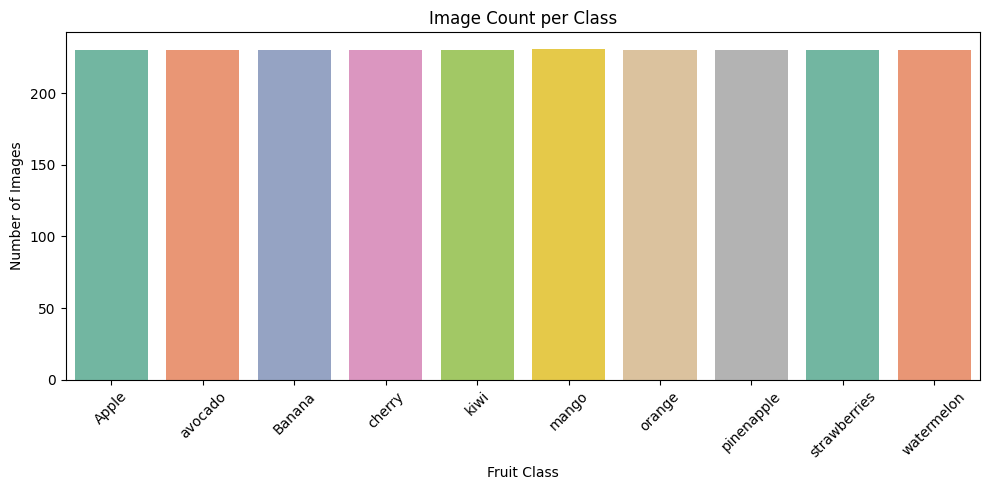

In [7]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Count images per class
class_counts = Counter(labels)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=[class_counts[i] for i in range(len(class_names))], palette='Set2')
plt.title("Image Count per Class")
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Flattening Images for PCA

In [8]:
# Convert RGB images to grayscale and flatten
def flatten_resized_images(images):
    gray_images = tf.image.rgb_to_grayscale(images).numpy()
    flat = gray_images.reshape((gray_images.shape[0], -1))
    return flat

flat_features = flatten_resized_images(resized_images)
print("Flat feature shape:", flat_features.shape)


Flat feature shape: (2301, 16384)


## 6. PCA Visualization

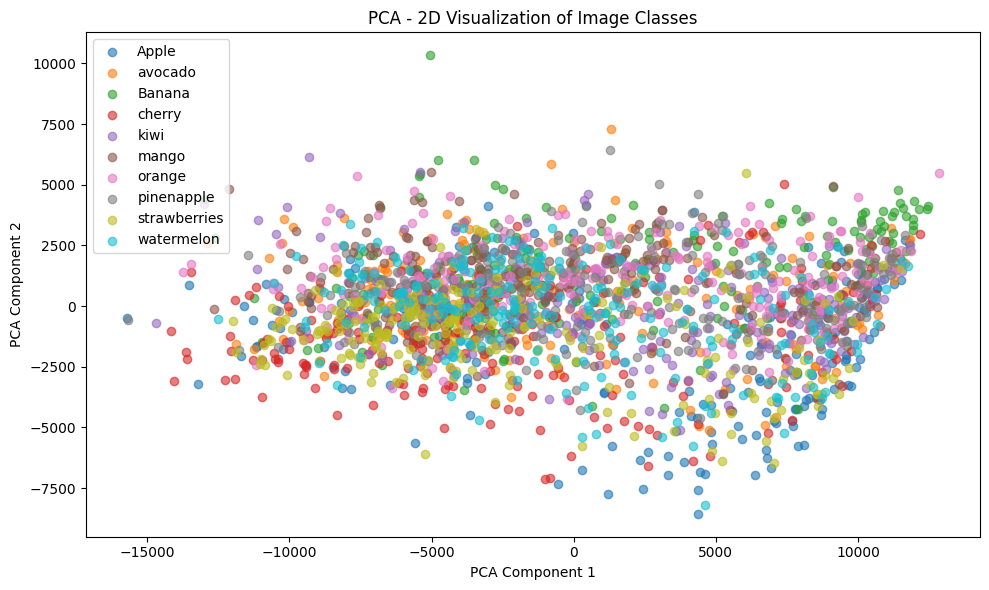

In [9]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_features)

# Plot PCA result
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    idxs = [j for j, lbl in enumerate(labels[:len(pca_result)]) if lbl == i]
    plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=class_name, alpha=0.6)

plt.title("PCA - 2D Visualization of Image Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Blur Detection using Laplacian Variance

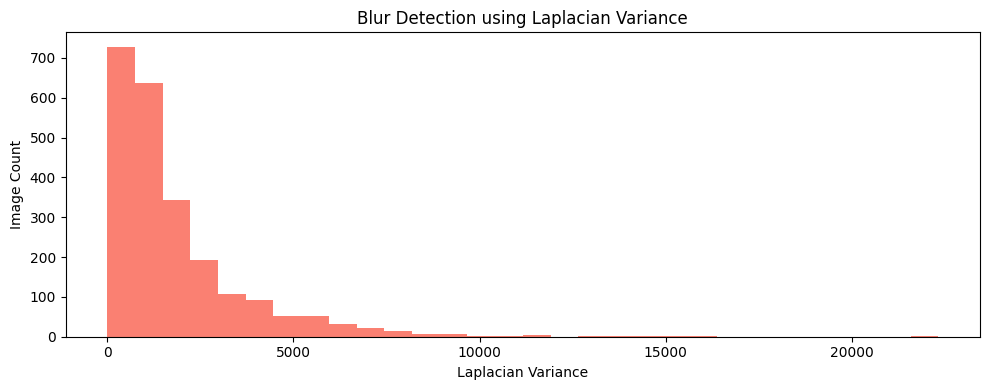

In [10]:
def detect_blur(image_paths):
    blur_scores = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        blur_scores.append(laplacian_var)
    return blur_scores

blur_scores = detect_blur(image_paths)

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(blur_scores, bins=30, color='salmon')
plt.title("Blur Detection using Laplacian Variance")
plt.xlabel("Laplacian Variance")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

## 8. Image Augmentation using TensorFlow’s ImageDataGenerator

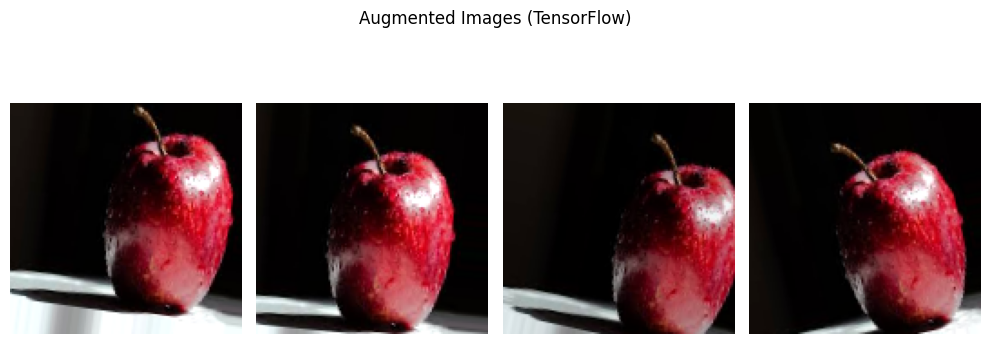

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator with basic augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Pick one image to demonstrate
sample_image = resized_images[0].reshape((1, 128, 128, 3))

# Generate augmented versions
aug_iter = datagen.flow(sample_image, batch_size=1)

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    batch = next(aug_iter)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
plt.suptitle("Augmented Images (TensorFlow)")
plt.tight_layout()
plt.show()


## 9. Texture Feature Extraction using LBP
 

In [12]:
from skimage.feature import local_binary_pattern

def extract_lbp_features_from_resized(images):
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return np.array(lbp_features)

lbp_feats = extract_lbp_features_from_resized(resized_images)
print("Extracted LBP feature shape:", lbp_feats.shape)

Extracted LBP feature shape: (2301, 26)


## Step 10: Import additional libraries

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

## Step 10.1: Define train and test directory paths (for deep learning)

In [15]:
train_dir = r'C:\Users\param\OneDrive\Desktop\EDA project\MY_data\train'
test_dir = r'C:\Users\param\OneDrive\Desktop\EDA project\MY_data\test'

## Step 10.2: Set up data generators

In [17]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


## Step 11: Use VGG16 pretrained model

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # reduces feature maps to 1D vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # random dropout of 50% neurons → helps prevent overfitting
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Step 12: Add callbacks (EarlyStopping + ModelCheckpoint)

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_fruit_model.h5', monitor='val_loss', save_best_only=True)

## Step 13: Train the model with train/test generators + callbacks

In [24]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1506 - loss: 2.3504

72/72 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.1517 - loss: 2.3478 - val_accuracy: 0.3668 - val_loss: 1.9855
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3910 - loss: 1.8183

72/72 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.3914 - loss: 1.8172 - val_accuracy: 0.4478 - val_loss: 1.8066
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5137 - loss: 1.5390

72/72 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.5139 - loss: 1.5386 - val_accuracy: 0.4566 - val_loss: 1.7270
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5484 - loss: 1.4065

72/72 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.5486 - loss: 1.4062 - val_accuracy: 0.4927 - val_loss: 1.7120
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5958 - loss: 1.2912

72/72 ━━━━━━━━━━━━━━━━━━━━ 448s 6s/step - accuracy: 0.5958 - loss: 1.2909 - val_accuracy: 0.4878 - val_loss: 1.6588


## Step 14: Plot training accuracy and loss

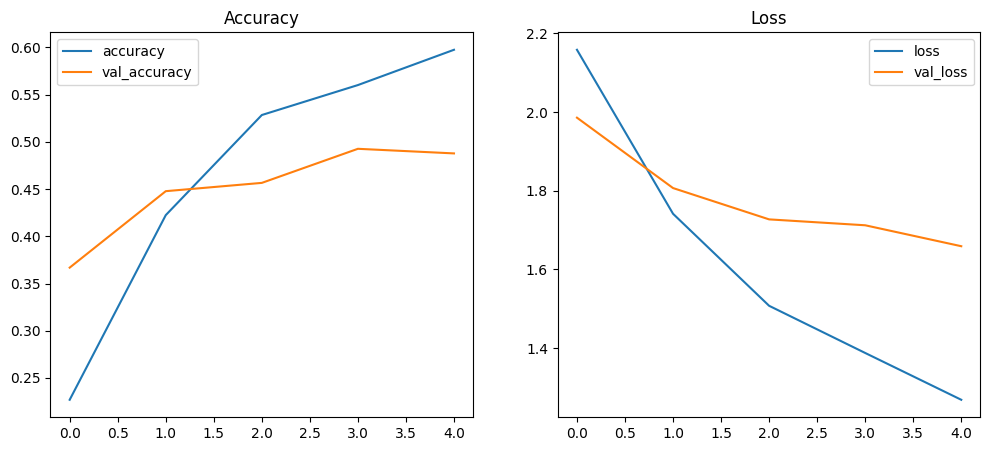

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()

## Step 15: Generate and plot confusion matrix

33/33 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step


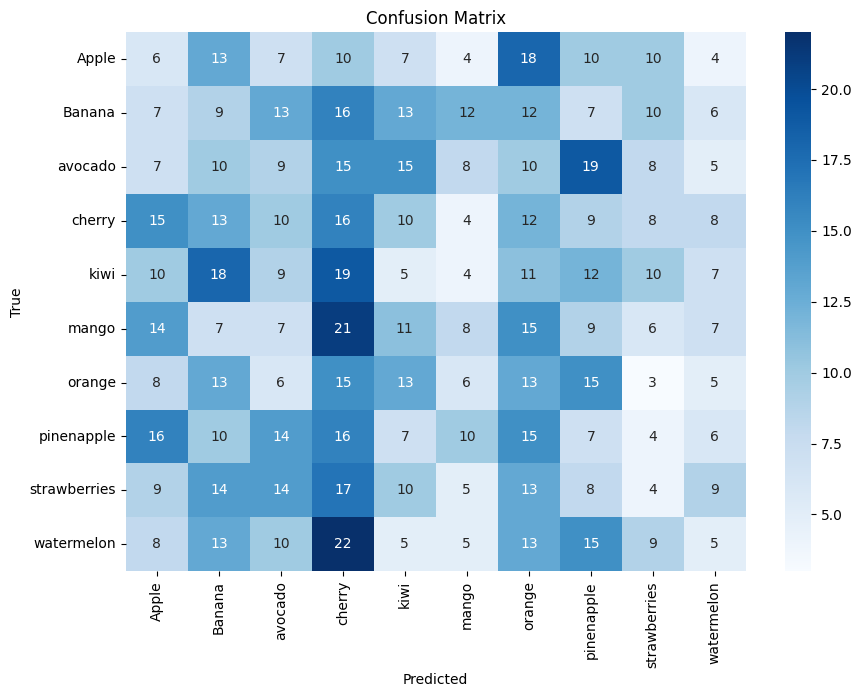

In [26]:
# Get true labels and predictions
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Step 16: Plot ROC curves (multi-class AUC)

C:\Users\param\AppData\Local\Temp\ipykernel_14220\4187767920.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


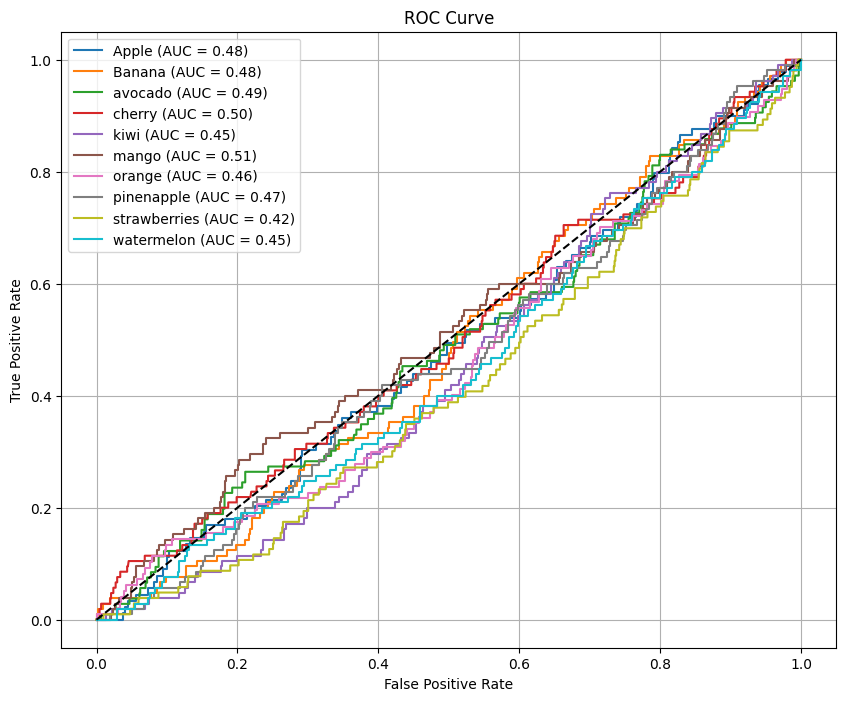

In [27]:
from sklearn.preprocessing import label_binarize

n_classes = len(train_data.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{list(train_data.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Step 17: Save the trained model

In [28]:
model.save('fruit_classification_model.h5')

## Step 18: Predict on a single image